In [75]:
import numpy as np
import matplotlib.pyplot as plt

def local_rec_K_matrix(hx, hy):
    K11 = (hx**2+hy**2)/hx/hy/3 # K22,K33,K44
    K12 = (hx**2-2*hy**2)/hx/hy/6 # K21,K34,K43
    K13 = -(hx**2+hy**2)/hx/hy/6 # K31,K24,K42
    K14 = -(2*hx**2-hy**2)/hx/hy/6 # K41,K23,K32
    return K11,K12,K13,K14

#insert correct index into final K matrix
def fill_local_index(a,b,c,d,num_nodes, distance_x, distance_y):
    K = np.zeros((num_nodes*num_nodes,num_nodes*num_nodes))
    A,B,C,D = local_rec_K_matrix(distance_x/(num_nodes-1),distance_y/(num_nodes-1))
    K[a,a] = K[b,b] = K[c,c] = K[d,d] = A
    K[a,b] = K[b,a] = K[c,d] = K[d,c] = B
    K[a,c] = K[c,a] = K[b,d] = K[d,b] = C
    K[a,d] = K[d,a] = K[b,c] = K[c,b] = D
    return K

def global_matrix_rectangular(num_nodes, k1, k2, distance_x, distance_y):
    res = np.zeros((num_nodes*num_nodes,num_nodes*num_nodes))
    for i in range(num_nodes - 1):
        for j in range(num_nodes - 1):
            if j <= (num_nodes-1)/2:
                k = k1
            else:
                k = k2
            res += k*fill_local_index(num_nodes*i+j,num_nodes*i+j+1,num_nodes*(i+1)+j+1,num_nodes*(i+1)+j, num_nodes, distance_x, distance_y)
    return res



In [76]:
def apply_boundary_conditions(K_global, F_global, T_left, T_right, T_top, T_bottom, num_nodes):
    s = K_global.shape[0]

    if T_left is not None:
        for i in range(s):
            if i % num_nodes == 0:
                K_global[i, :] = 0
                K_global[i, i] = 1
                F_global[i] = T_left

    if T_right is not None:
        for i in range(s):
            if (i + num_nodes + 1) % num_nodes == 0:
                K_global[i, :] = 0
                K_global[i, i] = 1
                F_global[i] = T_right

    if T_bottom is not None:
        for i in range(num_nodes):
            K_global[i, :] = 0
            K_global[i, i] = 1
            F_global[i] = T_bottom

    if T_top is not None:
        for i in range(num_nodes * (num_nodes - 1), s):
            K_global[i, :] = 0
            K_global[i, i] = 1
            F_global[i] = T_top

    return K_global, F_global

In [77]:
def apply_boundary_conditions2(K_global, F_global, q_left, q_right, q_top, q_bottom, num_nodes, distance_x, distance_y):
    s = K_global.shape[0] 
    dx = distance_x/num_nodes  
    dy = distance_y/num_nodes  

    if q_left is not None:
        for i in range(s): 
            if i % num_nodes == 0:
                F_global[i] += q_left*dy

    if q_right is not None:
        for i in range(s):
            if i % num_nodes == num_nodes - 1:
                F_global[i] += q_right*dy

    if q_bottom is not None:
        for i in range(num_nodes):  
            F_global[i] += q_bottom*dx
    if q_top is not None:
        for i in range(num_nodes * (num_nodes - 1), s):  
            F_global[i] += q_top*dx

    return K_global, F_global


In [78]:
#open file for parameters
variables = {}

with open("values.txt") as f:
    for line in f:
        parts = line.strip().split("=")
        if len(parts) == 2: 
            name, value = parts
            value = value.strip()
            variables[name.strip()] = None if value == "None" else float(value)  
            
#pass in the values
num_nodes = int(variables["num_nodes"])
distance_x = variables["distance_x"]
distance_y = variables["distance_y"]
k1 = variables["k1"]
k2 = variables["k2"]
T_left = variables["T_left"] 
T_right = variables["T_right"]
T_top = variables["T_top"] 
T_bottom = variables["T_bottom"]
q_left = variables["q_left"] 
q_right = variables["q_right"]
q_top = variables["q_top"]
q_bottom = variables["q_bottom"]

print(f"num_nodes: {num_nodes}")
print(f"distance_x: {distance_x} m")
print(f"distance_y: {distance_y} m")
print(f"k1: {k1} W/(m*K)")
print(f"k2: {k2} W/(m*K)")
print(f"T_left: {T_left} K")
print(f"T_right: {T_right} K")
print(f"T_top: {T_top} K")
print(f"T_bottom: {T_bottom} K")
print(f"q_left: {q_left} W/m^2")
print(f"q_right: {q_right} W/m^2")
print(f"q_top: {q_top} W/m^2")
print(f"q_bottom: {q_bottom} W/m^2")

num_nodes: 11
distance_x: 2.0 m
distance_y: 1.0 m
k1: 1.4 W/(m*K)
k2: 0.5 W/(m*K)
T_left: 270.0 K
T_right: None K
T_top: 280.0 K
T_bottom: None K
q_left: None W/m^2
q_right: None W/m^2
q_top: None W/m^2
q_bottom: None W/m^2


In [79]:

def plot_rectangular_grid(U_rec, distance_x, distance_y):
    num_nodes_x, num_nodes_y = U_rec.shape
    x = np.linspace(0, distance_x, num_nodes_x)
    y = np.linspace(0, distance_y, num_nodes_y)

    plt.figure(figsize=(8, 6))

    # Plot the grid
    for i in range(num_nodes_x): 
        plt.plot([x[i], x[i]], [0, distance_y], color='black', linewidth=0.7)
    for j in range(num_nodes_y): 
        plt.plot([0, distance_x], [y[j], y[j]], color='black', linewidth=0.7)

    plt.contourf(x, y, U_rec, levels=20, cmap='viridis')
    plt.colorbar(label='Temperature/Field Value')

    plt.title('Rectangular Grid with Solution')
    plt.xlabel('X (distance)')
    plt.ylabel('Y (distance)')
    plt.xlim(0, distance_x)
    plt.ylim(0, distance_y)
    plt.gca().set_aspect('equal')  
    plt.show()





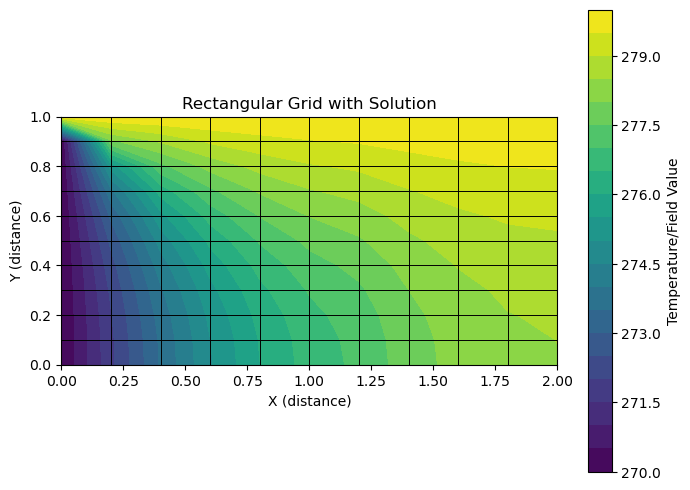

In [80]:
K_global = global_matrix_rectangular(num_nodes, k1, k2, distance_x, distance_y)
F_global = np.zeros(K_global.shape[0])

K1, F1 = apply_boundary_conditions(K_global, F_global, T_left, T_right, T_top, T_bottom, num_nodes)
K2, F2 = apply_boundary_conditions2(K_global, F_global, q_left, q_right, q_top, q_bottom, num_nodes, distance_x, distance_y)
U = np.dot(np.linalg.pinv(K1), F1)
U = U.reshape((num_nodes, num_nodes))
np.savetxt("result_rec",U)

plot_rectangular_grid(U, distance_x, distance_y)